In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

plt.style.use("ggplot")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/movie-reviews-homework/movie_data.csv


## Read the Data

In [2]:
# Read the data
data = pd.read_csv("/kaggle/input/movie-reviews-homework/movie_data.csv")
data.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


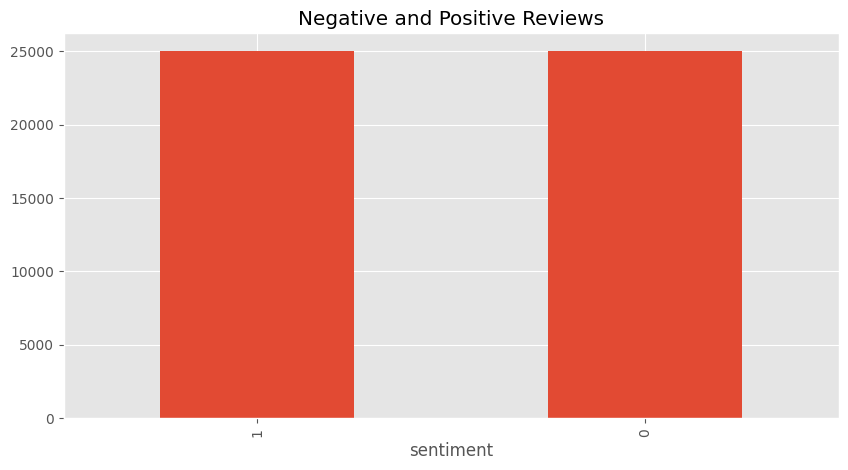

In [3]:
# Amount of Positive and Negative Reviews
data.sentiment.value_counts().plot(kind= "bar", 
                                   title= "Negative and Positive Reviews", figsize= (10, 5))
plt.show()

## Cleaning the Data

In [4]:
example = data.review[0]
example

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

In [5]:
# Drop punctuation marks and labels (<br />). 
review = re.sub(r'<(?:br\s*\/?)>|["*\\.!,():\-0-9;]+', ' ', example).lower()
review

"in   the teenager martha moxley  maggie grace  moves to the high class area of belle haven  greenwich  connecticut  on the mischief night  eve of halloween  she was murdered in the backyard of her house and her murder remained unsolved  twenty two years later  the writer mark fuhrman  christopher meloni  who is a former la detective that has fallen in disgrace for perjury in o j  simpson trial and moved to idaho  decides to investigate the case with his partner stephen weeks  andrew mitchell  with the purpose of writing a book  the locals squirm and do not welcome them  but with the support of the retired detective steve carroll  robert forster  that was in charge of the investigation in the  's  they discover the criminal and a net of power and money to cover the murder    murder in greenwich  is a good tv movie  with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a kennedy  the powerful and rich family used their infl

In [6]:
# Drop stopwords and transform conjugated verbs.
ps = PorterStemmer()
review = [ps.stem(word) for word in review.split() if not word in set(stopwords.words('english'))]
review = " ".join(review)
review

"teenag martha moxley maggi grace move high class area bell greenwich connecticut mischief night eve halloween murder backyard hous murder remain unsolv twenti two year later writer mark fuhrman christoph meloni former la detect fallen disgrac perjuri j simpson trial move idaho decid investig case partner stephen week andrew mitchel purpos write book local squirm welcom support retir detect steve carrol robert forster charg investig 's discov crimin net power money cover murder murder greenwich good tv movi true stori murder fifteen year old girl commit wealthi teenag whose mother kennedi power rich famili use influenc cover murder twenti year howev snoopi detect convict perjur disgrac abl disclos hideou crime commit screenplay show investig mark last day martha parallel lack emot dramat vote seven titl brazil avail"

In [7]:
# Function to Clean the Data
def clean_data(review):
    review = re.sub(r'<(?:br\s*\/?)>|["*\\.!,():\-0-9]+', ' ', review).lower()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review.split() if not word in set(stopwords.words('english'))]
    review = " ".join(review)
    return review

In [8]:
# Revies Preprocessing

corpus = {}
for i, review in data.iterrows():
    corpus[i] = [clean_data(review[0])]
    if i % 100 == 0: 
        print("*", end= '')

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [9]:
# Show Corpus
reviews = pd.DataFrame(corpus).T
reviews = reviews.rename(columns = {0: "Reviews"}).reset_index().set_index("index")
reviews.head(5)

,Reviews
index,
0,teenag martha moxley maggi grace move high cla...
1,ok realli like kri kristofferson usual easi go...
2,spoiler read think watch movi although would w...
3,hi peopl seen wonder movi im sure thet would l...
4,recent bought dvd forget much hate movi versio...


## Bag of Words


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features= 5000)
bag_words = cv.fit_transform(reviews.values.reshape(-1)).toarray()
sentiment = data.sentiment.astype(int).values
print(f"Bag Shape: {bag_words.shape} \n Sentiment Shape: {sentiment.size}")

Bag Shape: (50000, 5000) 
 Sentiment Shape: 50000


In [11]:
# Split data into training and testing sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(bag_words, sentiment, train_size = 0.95)
print(f"Train: {x_train.shape} \n Test: {x_test.shape}")

Train: (47500, 5000) 
 Test: (2500, 5000)


## Build the ANN

In [12]:
# Build the Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(units= 10, activation= "tanh", input_dim = x_train.shape[1]))
model.add(Dropout(rate= 1/4))
model.add(Dense(units= 10, activation= "tanh"))
model.add(Dropout(rate= 1/4))
model.add(Dense(units= 1, activation= "sigmoid"))

model.compile(optimizer= "adam", 
             loss= "binary_crossentropy",
             metrics= "accuracy")
model.fit(x_train, y_train,
         epochs= 50, batch_size= 128)

Epoch 1/50
372/372 [==============================] - 7s 5ms/step - loss: 0.3637 - accuracy: 0.8476
Epoch 2/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2672 - accuracy: 0.8973
Epoch 3/50
372/372 [==============================] - 2s 6ms/step - loss: 0.2459 - accuracy: 0.9064
Epoch 4/50
372/372 [==============================] - 2s 6ms/step - loss: 0.2342 - accuracy: 0.9127
Epoch 5/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2265 - accuracy: 0.9165
Epoch 6/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2196 - accuracy: 0.9180
Epoch 7/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2140 - accuracy: 0.9204
Epoch 8/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2092 - accuracy: 0.9221
Epoch 9/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2059 - accuracy: 0.9240
Epoch 10/50
372/372 [==============================] - 2s 5ms/step - loss: 0.2007 - accuracy: 0.9241

## Evaluate the Model

In [13]:
from sklearn.metrics import confusion_matrix

x_set, y_set = x_test, y_test
y_pred = (model.predict(x_set) > 0.5)

cm = confusion_matrix(y_set, y_pred)
cm

79/79 [==============================] - 0s 2ms/step


array([[1105,  165],
       [ 152, 1078]])

In [14]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss: {loss} \t Accuracy: {accuracy}")

79/79 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8732
Loss: 0.4315847158432007 	 Accuracy: 0.873199999332428


In [15]:
example

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

In [16]:
x = clean_data(example)
x = cv.transform([x]).toarray()
y = data.sentiment[data.review == example].iloc[0]

print(f"review: {x} \n Target: {y}")

review: [[0 0 0 ... 0 0 0]] 
 Target: 1


In [17]:
y_pred = model.predict(x)
print("Valoracion Buena") if y_pred > 0.5 else print("Valoracion Mala")

1/1 [==============================] - 0s 19ms/step
Valoracion Buena
